# Adrian Jaśkowiec

## 1. Physical Problem Description

This notebook models the one-dimensional transport of a scalar quantity, such as heat or a pollutant concentration, subject to both **advection** and **diffusion**. The governing equation is the advection-diffusion equation:
 
$$\partial_t \psi + u \partial_x \psi - \mu \partial_x^2 \psi = 0$$
 
Where:

- $\psi(x, t)$ is the scalar field (e.g., temperature, concentration) at position $x$ and time $t$.
- $u$ is the constant advection velocity (representing bulk flow of the medium).
- $\mu$ is the constant diffusion coefficient (representing transport due to random motion or gradients).
 
A physical example could be the temperature distribution $\psi$ in a one-dimensional rod or pipe of length $L$. Heat is transported along the rod due to conduction (diffusion, governed by $\mu$) and also carried along by a fluid flowing through the pipe with velocity $u$ (advection). We will assume the ends of the domain are connected (periodic boundary conditions) for simplicity in finding an analytic solution.

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

## 2. Analytic Solution

For the advection-diffusion equation on a domain $x \in [0, L]$ with periodic boundary conditions $\psi(0, t) = \psi(L, t)$ and an initial condition $\psi(x, 0) = \sin(2\pi x / L)$, the analytic solution is known:
 
$$\psi(x, t) = e^{-\mu (2\pi/L)^2 t} \sin\left(\frac{2\pi}{L} (x - ut)\right)$$
 
This solution represents a sine wave that propagates with velocity $u$ (advection) while its amplitude decays exponentially due to diffusion (governed by $\mu$).

In [2]:
L = 10.0   
mu = 0.1   
u = 0.5    
t_max = 5.0
nx = 100   
cfl = 0.8  

dx = L / nx
# Stability requires C + 2D <= 1, where C = u*dt/dx, D = mu*dt/dx^2
dt_stability_limit = 1.0 / (abs(u) / dx + 2 * mu / (dx**2))
dt = cfl * dt_stability_limit
nt = int(t_max / dt)

x = np.linspace(0, L, nx, endpoint=False)

print(f"Domain Length (L): {L}")
print(f"Advection Velocity (u): {u}")
print(f"Diffusion Coefficient (mu): {mu}")
print(f"Spatial points (nx): {nx}")
print(f"Spatial step (dx): {dx:.4f}")
print(f"Max time (t_max): {t_max}")
print(f"Time steps (nt): {nt}")
print(f"Time step (dt): {dt:.4f} (stability limit: {dt_stability_limit:.4f}, CFL: {cfl})")
print(f"Advection Courant Number (C = u*dt/dx): {abs(u)*dt/dx:.3f}")
print(f"Diffusion Number (D = mu*dt/dx^2): {mu*dt/dx**2:.3f}")
print(f"C + 2D: {abs(u)*dt/dx + 2*mu*dt/dx**2:.3f} (should be <= 1)")

Domain Length (L): 10.0
Advection Velocity (u): 0.5
Diffusion Coefficient (mu): 0.1
Spatial points (nx): 100
Spatial step (dx): 0.1000
Max time (t_max): 5.0
Time steps (nt): 156
Time step (dt): 0.0320 (stability limit: 0.0400, CFL: 0.8)
Advection Courant Number (C = u*dt/dx): 0.160
Diffusion Number (D = mu*dt/dx^2): 0.320
C + 2D: 0.800 (should be <= 1)


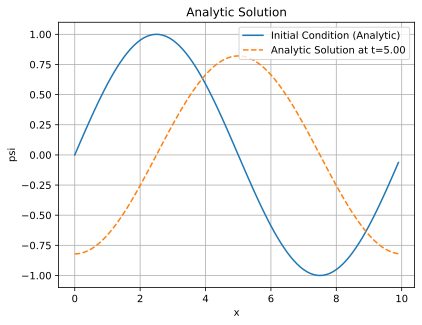

In [3]:
class PsiAnalytic:
    def __init__(self, *, u, mu, L):
        self.u = u
        self.mu = mu
        self.L = L
        self.k = 2 * np.pi / L

    def __call__(self, *, x, t):
        amplitude_decay = np.exp(-self.mu * self.k**2 * t)
        wave_propagation = np.sin(self.k * (x - self.u * t))
        return amplitude_decay * wave_propagation

psi_analytic_func = PsiAnalytic(u=u, mu=mu, L=L)

pyplot.figure()
pyplot.plot(x, psi_analytic_func(x=x, t=0), label='Initial Condition (Analytic)')
pyplot.plot(x, psi_analytic_func(x=x, t=t_max), label=f'Analytic Solution at t={t_max:.2f}', linestyle='--')
pyplot.title('Analytic Solution')
pyplot.xlabel('x')
pyplot.ylabel('psi')
pyplot.grid()
pyplot.legend()
show_plot('analytic_solution.pdf')

## 3. Numerical Integration (Upwind Scheme for Advection)
 
We discretize the advection-diffusion equation using:

- **Forward Euler** for the time derivative $\partial_t \psi \approx \frac{\psi_i^{n+1} - \psi_i^n}{\Delta t}$.
- **Upwind Scheme** for the advection term $u \partial_x \psi$. If $u > 0$, $u \partial_x \psi \approx u \frac{\psi_i^n - \psi_{i-1}^n}{\Delta x}$. If $u < 0$, $u \partial_x \psi \approx u \frac{\psi_{i+1}^n - \psi_i^n}{\Delta x}$.
- **Centered Difference (FTCS)** for the diffusion term $\mu \partial_x^2 \psi \approx \mu \frac{\psi_{i+1}^n - 2 \psi_i^n + \psi_{i-1}^n}{(\Delta x)^2}$.

Combining these gives the update rule:
$$\psi_i^{n+1} = \psi_i^n - \Delta t \left( u \frac{\psi_i^n - \psi_{i-1}^n}{\Delta x} \right) + \Delta t \left( \mu \frac{\psi_{i+1}^n - 2 \psi_i^n + \psi_{i-1}^n}{(\Delta x)^2} \right) \quad (\text{if } u > 0)$$
$$\psi_i^{n+1} = \psi_i^n - C (\psi_i^n - \psi_{i-1}^n) + D (\psi_{i+1}^n - 2 \psi_i^n + \psi_{i-1}^n) \quad (\text{if } u > 0)$$
where $C = u \Delta t / \Delta x$ is the advection Courant number and $D = \mu \Delta t / (\Delta x)^2$ is the diffusion number. A similar expression holds for $u < 0$.

In [4]:
psi_numerical = psi_analytic_func(x=x, t=0)
psi_history = [psi_numerical.copy()]

C = u * dt / dx
D = mu * dt / (dx**2)

anim_steps_between_frames = max(1, nt // 100)
time_points_for_anim = [0.0]

print(f"Storing animation frame every {anim_steps_between_frames} steps.")

for n in range(nt):
    psi_prev = psi_numerical.copy()
    
    psi_im1 = np.roll(psi_prev, 1) # psi_{i-1} using periodic boundary
    psi_ip1 = np.roll(psi_prev, -1) # psi_{i+1} using periodic boundary


    diffusion_term = D * (psi_ip1 - 2 * psi_prev + psi_im1)


    if u >= 0:
        advection_term = C * (psi_prev - psi_im1)
    else:
        advection_term = C * (psi_ip1 - psi_prev)


    psi_numerical = psi_prev - advection_term + diffusion_term
    

    if (n + 1) % anim_steps_between_frames == 0:
        psi_history.append(psi_numerical.copy())
        time_points_for_anim.append((n + 1) * dt)
        
if nt % anim_steps_between_frames != 0:
     psi_history.append(psi_numerical.copy())
     time_points_for_anim.append(t_max)

psi_final_numerical = psi_numerical

print(f"Numerical integration complete. Stored {len(psi_history)} frames for animation.")


Storing animation frame every 1 steps.
Numerical integration complete. Stored 157 frames for animation.


## 4. Comparison

We compare the numerical solution obtained at $t = t_{\text{max}}$ with the analytic solution at the same time. We visualize this comparison with a plot and calculate the L2 error norm as a quantitative measure of the difference.

The L2 error norm is calculated as:
$$E_2 = \sqrt{\Delta x \sum_{i=0}^{nx-1} (\psi_{\text{numerical}, i}(t_{\text{max}}) - \psi_{\text{analytic}}(x_i, t_{\text{max}}))^2}$$


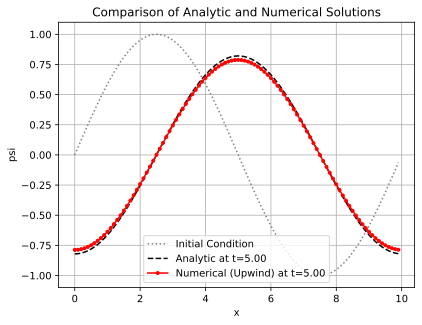

L2 Error Norm at t=5.00: 7.4061e-02


In [5]:
psi_final_analytic = psi_analytic_func(x=x, t=t_max)

pyplot.figure()
pyplot.plot(x, psi_analytic_func(x=x, t=0), label='Initial Condition', color='gray', linestyle=':')
pyplot.plot(x, psi_final_analytic, label=f'Analytic at t={t_max:.2f}', color='black', linestyle='--')
pyplot.plot(x, psi_final_numerical, label=f'Numerical (Upwind) at t={t_max:.2f}', color='red', marker='o', markersize=3, linestyle='-')
pyplot.title('Comparison of Analytic and Numerical Solutions')
pyplot.xlabel('x')
pyplot.ylabel('psi')
pyplot.grid()
pyplot.legend()
show_plot('comparison.pdf')

# Quantitative Comparison (L2 Error Norm)
error = psi_final_numerical - psi_final_analytic
l2_error = np.sqrt(dx * np.sum(error**2))

print(f"L2 Error Norm at t={t_max:.2f}: {l2_error:.4e}")



# 5. Animation


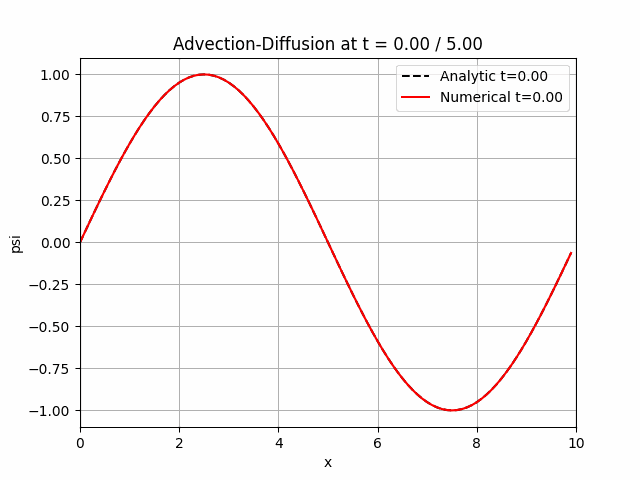

HTML(value="<a href='./tmp8asn_ifo.gif' target='_blank'>./tmp8asn_ifo.gif</a><br>")

In [6]:
def plot_for_anim(frame_index):
    fig = pyplot.figure()
    t_current = time_points_for_anim[frame_index]
    psi_numerical_current = psi_history[frame_index]
    psi_analytic_current = psi_analytic_func(x=x, t=t_current)
    
    pyplot.plot(x, psi_analytic_current, label=f'Analytic t={t_current:.2f}', color='black', linestyle='--')
    pyplot.plot(x, psi_numerical_current, label=f'Numerical t={t_current:.2f}', color='red', linestyle='-')
    
    initial_max = np.max(np.abs(psi_history[0]))
    pyplot.ylim(-initial_max * 1.1, initial_max * 1.1) 
    pyplot.xlim(0, L)
    pyplot.title(f'Advection-Diffusion at t = {t_current:.2f} / {t_max:.2f}')
    pyplot.xlabel('x')
    pyplot.ylabel('psi')
    pyplot.grid()
    pyplot.legend()
    return fig

animation_frames = range(len(psi_history)) 
show_anim(plot_for_anim, animation_frames)

# 6. Conclusion

This notebook successfully implemented and evaluated a numerical solution for the one-dimensional advection-diffusion equation, comparing it against a known analytic solution. The goal was to model the transport of a scalar quantity $\psi$ subject to both bulk movement (advection) and spreading due to gradients (diffusion), using an upwind scheme for advection and FTCS for diffusion.

**Observations:**

- The plots comparing the numerical and analytic solutions show strong visual agreement throughout the simulation. Both methods clearly depict the key physical processes: the sine wave propagates across the domain due to advection (velocity $u$) and its amplitude decays over time due to diffusion (coefficient $\mu$). A slight visual difference between the numerical and analytic curves emerges as the simulation approaches the final time $t = 5.0$.
- As expected from the diffusion term $-\mu \partial_x^2 \psi$ and its effect in the analytic solution $e^{-\mu (2\pi/L)^2 t}$, both the numerical and analytic solutions exhibit a decay in the peak amplitude (flattening of the sine wave) as time progresses.
- The L2 error norm calculated at the final time step ($t=5.0$) was found to be $\approx 7.4 \times 10^{-2}$. This relatively small value indicates good quantitative agreement between the numerical simulation and the exact analytic result.